# CNN for lesion classification

## 1. Brief CNN theory

A Convolutional Neural Network (CNN, or ConvNet) is a type of **feed-forward** artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of the animal visual cortex.

<img src="images/convnets_cover.png" width="70%" />

> source: https://flickrcode.files.wordpress.com/2014/10/conv-net2.png

### 1.1 Structure of a CNN

> A more detailed overview of what CNNs do would be that you take the image, pass it through a series of convolutional, nonlinear, pooling (downsampling), and fully connected layers, and get an output. As we said earlier, the output can be a single class or a probability of classes that best describes the image. 

source: [1]

#### Convolutional Layer

The first layer in a CNN is always a **Convolutional Layer**.

<img src="images/same_padding_no_strides.gif" width="50%">

#### Typical CNN Structure

A traditional CNN architecture consists of other layers interspaced between convolution layers

<img src="images/Table.png">

#### Pooling layer

After some ReLu layers, **pooling layer** is typically applied.

<img src="images/MaxPool.png" width="80%"/>

Pooling reduces the amount of parameters (helping with computional efficiency) and controls overfitting

## 2. We build one using keras and tensorflow

### 2.1 Preparation

In [1]:
# setup code for this notebook
import numpy as np
import matplotlib.pyplot as plt
from functions import data, Timer
timer = Timer()

# This makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### The ultra sound scan data
- 163 scans total, clinically confirmed as having either bening or malignant (cancerous) lesions 
- 100 scans for training, 63 for testing
- Training data was passed through 7 transformations to give us 800 training images total
- We balanced the training data to have half malignant and half benign
- Since the malignant cases were less than benign cases, we use only 528 images for training
- Emperically we have found this improves our overall performance
- Testing images not transformed
- Both training and testing images were resized to 224X224
- Raw pngs then converted to numpy arrays and saved

In [2]:
# Import keras libraries
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [3]:
img_rows, img_cols = 224, 224 # 224, 224 resized down from 360, 528
color_channels = 3

if K.image_data_format() == 'channels_first':
    input_shape = (color_channels, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, color_channels)
    
print('Input shape', input_shape)

Input shape (224, 224, 3)


### 2.2 A CNN

In [4]:
# values for the convnet

# number of convolutional filters to use
filters = 32
# size of pooling area
pooling_area = 2
# conv kernel size
conv_kernel = 3


In [5]:
# We define the cnn model
def buildModelStructure():
    model = Sequential()

    model.add(Conv2D(filters, (conv_kernel, conv_kernel), padding='valid',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling_area, pooling_area)))

    model.add(Conv2D(filters, (conv_kernel, conv_kernel)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling_area, pooling_area)))

    model.add(Conv2D(64, (conv_kernel, conv_kernel)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pooling_area, pooling_area)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

In [6]:
# Visualize
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def visualize(model):
    model.summary()
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [7]:
# generator helpers
from keras.preprocessing.image import ImageDataGenerator

In [8]:
# data readers
base = "J:\\final year project\\code and models\\data\\augmented\\"
train_directory = base+'training'
validation_directory = base+'validation'

batch_size = 32

# normalization
train_generator = ImageDataGenerator(rescale=1./255)
validation_generator = ImageDataGenerator(rescale=1./255)

# this is a generator that will read scans found in
# the train directory, and indefinitely generate
# batches of image data
train_generator = train_generator.flow_from_directory(
        train_directory,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

# A  similar generator, for validation data
validation_generator = validation_generator.flow_from_directory(
        validation_directory,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

Found 400 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


In [9]:
def plot(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

In [10]:
# helpers for checkpointing and early stopping
from keras.callbacks import ModelCheckpoint # , EarlyStopping

best_model_file = 'best_cnn_dgen_model.h5'
# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1) 
best_model = ModelCheckpoint(best_model_file, verbose=True, save_best_only=True)

def testModel(optimizer='rmsprop', epochs=2, text="Training model"):
    # build model
    model = buildModelStructure()
    
    # Compile it
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    timer.start()
    network_history = model.fit_generator(
            train_generator, 
            steps_per_epoch=400,
            epochs=epochs,
            validation_data = validation_generator,
            validation_steps=128,
            verbose=True,
            callbacks=[best_model])
    timer.stop(text)
    plot(network_history)

Epoch 1/10
400/400 [==============================] - 164s 409ms/step - loss: 0.6959 - acc: 0.5004 - val_loss: 0.6939 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.69386, saving model to best_cnn_dgen_model.h5
Epoch 2/10
400/400 [==============================] - 143s 358ms/step - loss: 0.6950 - acc: 0.4877 - val_loss: 0.6938 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69386 to 0.69383, saving model to best_cnn_dgen_model.h5
Epoch 3/10
400/400 [==============================] - 144s 360ms/step - loss: 0.6950 - acc: 0.4814 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.69383 to 0.69323, saving model to best_cnn_dgen_model.h5
Epoch 4/10
400/400 [==============================] - 143s 357ms/step - loss: 0.6949 - acc: 0.4800 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00004: val_loss improved from 0.69323 to 0.69320, saving model to best_cnn_dgen_model.h5
Epoch 5/10
400/400 [==============================] - 143s 358ms/step - loss

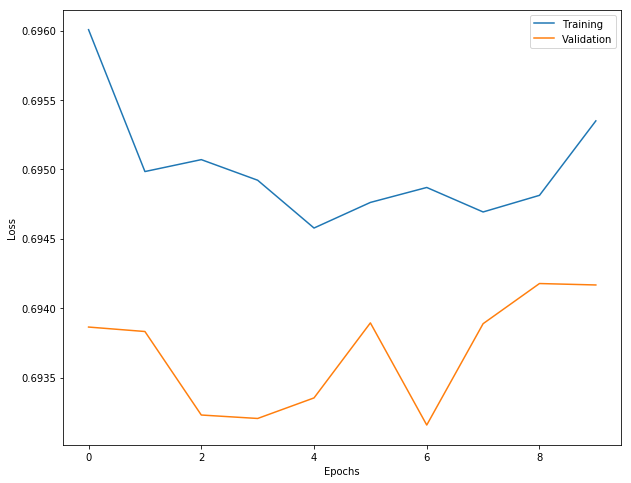

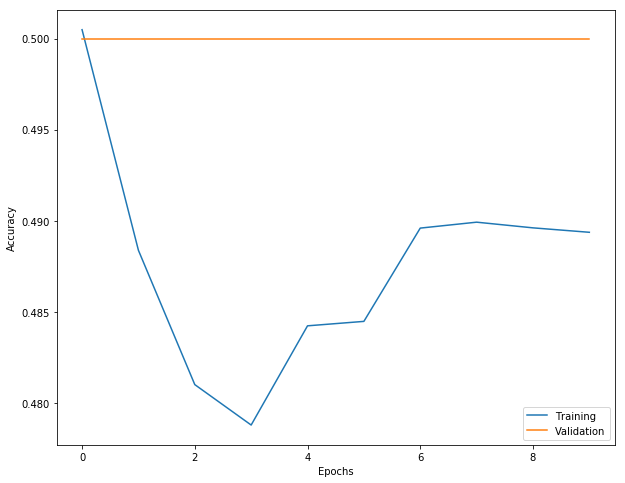

In [11]:
# We test SGD
from keras.optimizers import SGD
epochs = 10
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
testModel(sgd, epochs)

Epoch 1/10
400/400 [==============================] - 152s 380ms/step - loss: 0.2467 - acc: 0.8794 - val_loss: 1.7016 - val_acc: 0.5859

Epoch 00001: val_loss did not improve
Epoch 2/10
400/400 [==============================] - 150s 375ms/step - loss: 0.0353 - acc: 0.9892 - val_loss: 2.7529 - val_acc: 0.6328

Epoch 00002: val_loss did not improve
Epoch 3/10
400/400 [==============================] - 154s 385ms/step - loss: 0.0320 - acc: 0.9895 - val_loss: 3.7833 - val_acc: 0.5703

Epoch 00003: val_loss did not improve
Epoch 4/10
400/400 [==============================] - 149s 372ms/step - loss: 0.0153 - acc: 0.9941 - val_loss: 4.2580 - val_acc: 0.6484

Epoch 00004: val_loss did not improve
Epoch 5/10
400/400 [==============================] - 148s 371ms/step - loss: 0.0177 - acc: 0.9931 - val_loss: 4.5229 - val_acc: 0.6406

Epoch 00005: val_loss did not improve
Epoch 6/10
400/400 [==============================] - 149s 372ms/step - loss: 0.0128 - acc: 0.9955 - val_loss: 4.3113 - val_a

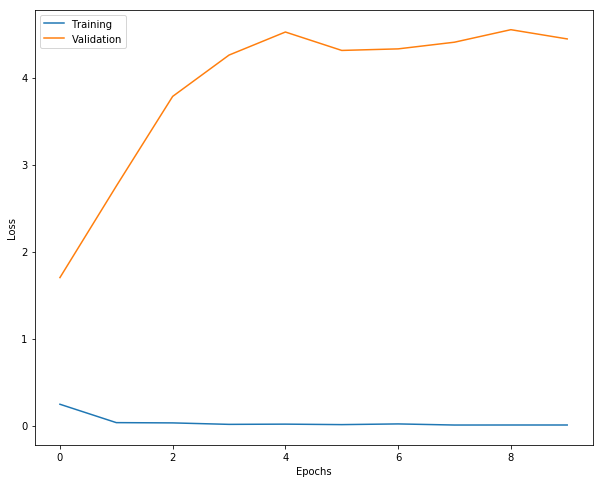

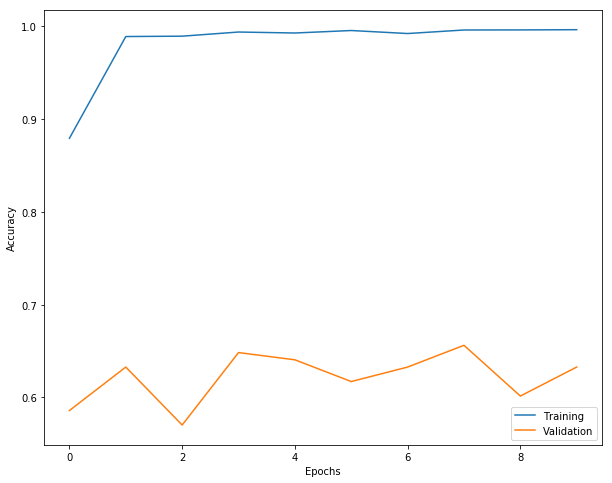

In [12]:
#Adam
epochs = 10
testModel('adam', epochs, "training model with adam")

Epoch 1/10
400/400 [==============================] - 152s 379ms/step - loss: 0.1935 - acc: 0.9142 - val_loss: 3.0490 - val_acc: 0.6016

Epoch 00001: val_loss did not improve
Epoch 2/10
400/400 [==============================] - 148s 371ms/step - loss: 0.0070 - acc: 0.9982 - val_loss: 4.7061 - val_acc: 0.5938

Epoch 00002: val_loss did not improve
Epoch 3/10
400/400 [==============================] - 147s 367ms/step - loss: 0.0056 - acc: 0.9988 - val_loss: 4.8994 - val_acc: 0.6094

Epoch 00003: val_loss did not improve
Epoch 4/10
400/400 [==============================] - 149s 372ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 5.3412 - val_acc: 0.6250

Epoch 00004: val_loss did not improve
Epoch 5/10
400/400 [==============================] - 147s 368ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 5.5268 - val_acc: 0.6328

Epoch 00005: val_loss did not improve
Epoch 6/10
400/400 [==============================] - 151s 377ms/step - loss: 0.0021 - acc: 0.9997 - val_loss: 6.0726 - val_a

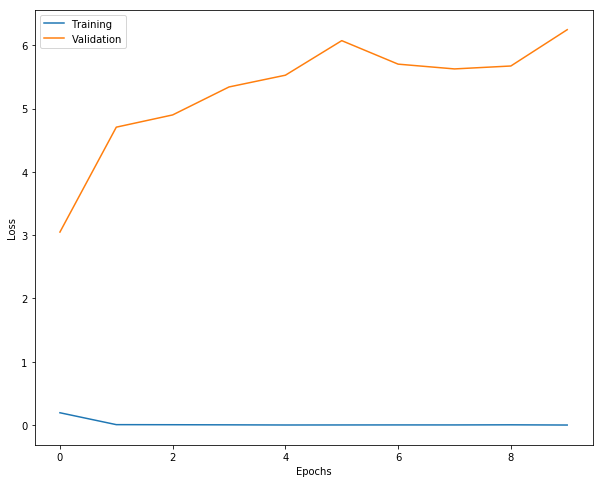

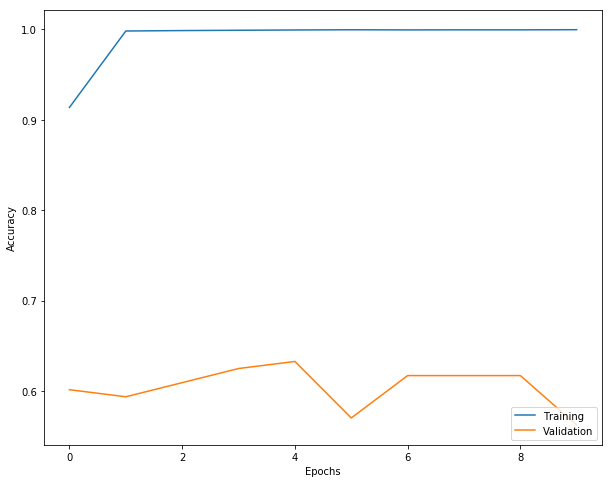

In [13]:
#Rmsprop
epochs = 10
testModel('rmsprop', epochs, "training model with rmsprop")

Epoch 1/10
400/400 [==============================] - 174s 436ms/step - loss: 0.4993 - acc: 0.7275 - val_loss: 1.0676 - val_acc: 0.6016

Epoch 00001: val_loss did not improve
Epoch 2/10
400/400 [==============================] - 1711s 4s/step - loss: 0.0198 - acc: 0.9945 - val_loss: 1.7856 - val_acc: 0.6172

Epoch 00002: val_loss did not improve
Epoch 3/10
400/400 [==============================] - 942s 2s/step - loss: 0.0047 - acc: 0.9988 - val_loss: 2.0273 - val_acc: 0.6641

Epoch 00003: val_loss did not improve
Epoch 4/10
400/400 [==============================] - 148s 370ms/step - loss: 0.0036 - acc: 0.9991 - val_loss: 1.8733 - val_acc: 0.6797

Epoch 00004: val_loss did not improve
Epoch 5/10
400/400 [==============================] - 147s 368ms/step - loss: 0.0024 - acc: 0.9992 - val_loss: 2.1108 - val_acc: 0.6562

Epoch 00005: val_loss did not improve
Epoch 6/10
400/400 [==============================] - 147s 369ms/step - loss: 0.0023 - acc: 0.9992 - val_loss: 2.4827 - val_acc: 0

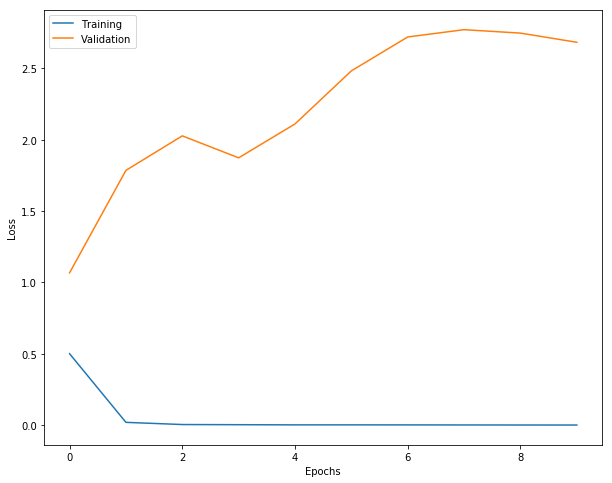

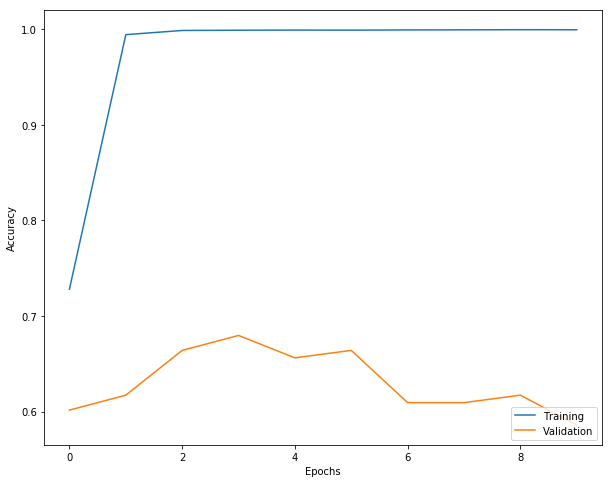

In [14]:
#Adagrad
epochs = 10
testModel('adagrad', epochs, "training model with adagrad")

### 2.3 Evaluating the Learning performance

Adagrad best

### References for images and some content:

\[1\] [https://adeshpande3.github.io/adeshpande3.github.io/]() 
<br> \[2\] ["Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/) by Michael Nielsen.
<br> \[3\] Deep learning with TensorFlow and Keras by Valerio Maggio